## Purpose of this code is to try and create a probability map for post-processing. This map will be used instead of thresholding

In [1]:
import numpy as np
from skimage import io
import math

### Defining the convolution matrix

In [2]:
n = 51 #for creating our nxn kernal: n must be odd
A = np.zeros([n, n])
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        separation = max(abs(((n-1)/2)-i), abs(((n-1)/2)-j))+1
        A[i][j] = math.exp(-separation/(math.floor(math.log(n, 2))))  #kernal is defined as a negative exponential function, with the origin at the center of the matrix. 

### Importing, padding, convolution

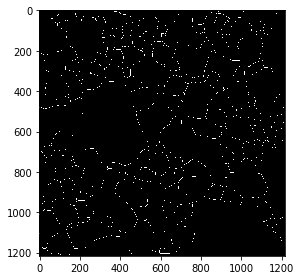

In [3]:
path = 'unet_skel.png'

img = io.imread(path,as_gray=True)
io.imshow(img)

In [4]:
#zero padding the image so the dimensions do not change after convolution

img_padded = np.zeros([img.shape[0]+(n-1), img.shape[1]+(n-1)])
img_padded[((n-1)//2):-((n-1)//2), ((n-1)//2):-((n-1)//2)] = img
img_padded.shape

(1266, 1266)

In [5]:
def matFunc(B, A): #B input, A kernal, C convolution output
    p, q, y, z = A.shape[0], A.shape[1], B.shape[0], B.shape[1]
    shape = (p, q) + (tuple(np.subtract((y, z), (p, q)) + 1))
    strides = (B.strides * 2)
    B = np.lib.stride_tricks.as_strided(B, shape=shape, strides=strides)

    C = np.einsum('pq,pqmn->mn', A, B)
    
    return C


C:\Users\alanm\anaconda3\envs\tf\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


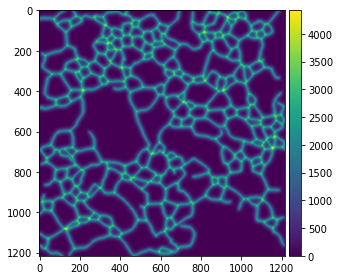

In [6]:
mapp = matFunc(img_padded, A)
io.imshow(mapp)

## Normalizing to a function

60
255


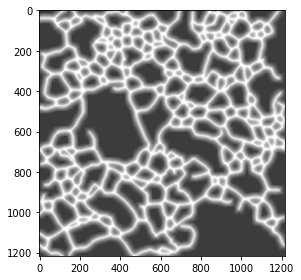

In [7]:
#by normalizing, we clip the values between 0 and 255 and make the data actually meaningful

uni = np.linspace(0, 255, mapp.shape[0]**2) ## define a more complex function here if desired. A uniform distribution is used here
uni = uni.reshape(mapp.shape)

from skimage.exposure import match_histograms

normalized_mapp = match_histograms(mapp, uni)
normalized_mapp = normalized_mapp.astype('uint8')
io.imshow(normalized_mapp)
print(np.min(normalized_mapp))
print(np.max(normalized_mapp))

In [8]:
io.imsave('map.png', normalized_mapp)

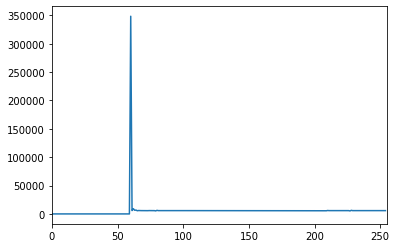

In [9]:
import matplotlib.pyplot as plt
img = io.imread('map.png')
hist, bins = np.histogram(img, bins=255, range=(0,255))
plt.figure()
plt.xlim([0, 255])
plt.plot(bins[0:-1], hist)
plt.show()